In [1]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# import plotly
# import plotly.express as px

# import lasio as las

# data = las.read('demo.las')
# log = data.df()

# # len(log.columns)
# log.columns

# # data.curves

# ## Vp & AI

# log['Vp'] = (1e6 / log['DT']) * 0.3048
# # in m/s

# log['AI'] = log['Vp'] * log['RHOB'] * 1000

# log['Vp'].isna().sum()

# log['M'] = log['RHOB']*1000*(log['Vp']**2)

# # Extract necessary logs
# depths = log.index
# vp = log['Vp']  # Replace 'VP' with the actual mnemonic for P-wave velocity
# vs = np.random.uniform(low=vp.min()*0.5, high=vp.max()*0.5, size=len(vp))  # Replace 'VS' with the actual mnemonic for S-wave velocity
# rho = log['RHOB']  # Replace 'RHOB' with the actual mnemonic for density

# # Define incidence angles from 0 to 40 degrees
# angles = np.arange(0, 41, 1)  # 0 to 40 degrees in 1-degree increments

# import bruges.reflection as refl

# # Initialize an array to store reflection coefficients
# rc_array = np.zeros((len(depths) - 1, len(angles)))

# for i in range(len(depths) - 1):
#     # Upper layer properties
#     vp1 = vp.iloc[i]
#     vs1 = vs[i]  # vs is a NumPy array, so index normally
#     rho1 = rho.iloc[i]
    
#     # Lower layer properties
#     vp2 = vp.iloc[i + 1]
#     vs2 = vs[i + 1]
#     rho2 = rho.iloc[i + 1]
    
#     # Computing RC using Shuey's approximation
#     rc = refl.shuey(vp1, vs1, rho1, vp2, vs2, rho2, angles)
    
#     # Store the computed reflection coefficients
#     rc_array[i, :] = rc

# # Create a DataFrame for reflection coefficients
# rc_df = pd.DataFrame(rc_array, columns=[f"{angle}°" for angle in angles], index=depths[:-1])

# rc_df   # has size of depth *  angles/offset (prestack)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasio

# for AVO modelling (zoeppritz, Aki-Richards, Shuey)
import bruges
import bruges.reflection as refl

# LAS file
data = lasio.read('demo.las')
log = data.df()

log['DT'] = log['DT'] / 0.3048       # µs/ft to µs/m
log['RHOB'] = log['RHOB'] * 1000     # g/cm³ to kg/m³
log['Vp'] = 1e6 / log['DT']
log['Vs'] = 0.8621 * log['Vp'] - 1172   # Estimate(Castagna’s mudrock line) NOT GIVEN in log
# AI
log['AI'] = log['Vp'] * log['RHOB']


In [3]:
# Shuey reflection coefficients RC
depths = log.index
vp = log['Vp'].values
vs = log['Vs'].values
rho = log['RHOB'].values
angles = np.arange(0, 41, 1)

rc_array = np.zeros((len(depths) - 1, len(angles)))
for i in range(len(depths) - 1):
    vp1, vs1, rho1 = vp[i], vs[i], rho[i]
    vp2, vs2, rho2 = vp[i + 1], vs[i + 1], rho[i + 1]
    # rc_array[i, :] = refl.shuey(vp1, vs1, rho1, vp2, vs2, rho2, angles)
    # rc_array[i, :] = refl.akirichards(vp1, vs1, rho1, vp2, vs2, rho2, angles)
    rc_array[i, :] = refl.zoeppritz(vp1, vs1, rho1, vp2, vs2, rho2, angles)

rc_df = pd.DataFrame(rc_array, columns=[f"{a}°" for a in angles], index=depths[:-1])

C:\Users\Admin\anaconda3\Lib\site-packages\bruges\reflection\reflection.py:291: RuntimeWarning: invalid value encountered in divide
  p = np.sin(theta1) / vp1  # Ray parameter.
C:\Users\Admin\AppData\Local\Temp\ipykernel_8460\2581204994.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  rc_array[i, :] = refl.zoeppritz(vp1, vs1, rho1, vp2, vs2, rho2, angles)


In [10]:
# Time-depth conversion (TWT)
dt_interval = np.nan_to_num(log['DT']) * 0.1524 / 1e6  # in seconds per sample
twt = np.cumsum(dt_interval) * 2  # two-way time
log['TWT'] = twt
# np.size(twt)

14430

In [4]:
# Resample AI on a regular time grid
dt = 0.001  # 1 ms
t_max = 2  # max time for synthetic in seconds
t = np.arange(0, t_max, dt)

AI_interp = np.interp(t, log['TWT'], log['AI'])

# Compute reflection coefficients in time domain
Rc_tdom = [(AI_interp[i+1] - AI_interp[i]) / (AI_interp[i+1] + AI_interp[i]) for i in range(len(AI_interp)-1)]
Rc_tdom.append(Rc_tdom[-1])  # pad last value
Rc_tdom = np.array(Rc_tdom)

In [11]:
# Ricker wavelet
def ricker(f, length, dt):
    t0 = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t0**2)) * np.exp(-(np.pi**2)*(f**2)*(t0**2))
    return t0, y

f_dom = 20 # Hz
w_length = 0.512
_, wavelet = ricker(f_dom, w_length, dt)

In [12]:
# Interpolate Shuey RCs to time grid and convolve with wavelet
rc_interp_dict = {}
for angle in rc_df.columns:
    rc_vals = rc_df[angle].values
    valid_idx = ~np.isnan(log['TWT'].values[:-1])
    rc_interp = np.interp(t, log['TWT'].values[:-1][valid_idx], rc_vals[valid_idx])
    rc_interp_dict[angle] = rc_interp

synthetics = {}
for angle, rc in rc_interp_dict.items():
    synthetics[angle] = np.convolve(rc, wavelet, mode='same')

syn_df = pd.DataFrame(synthetics, index=t)

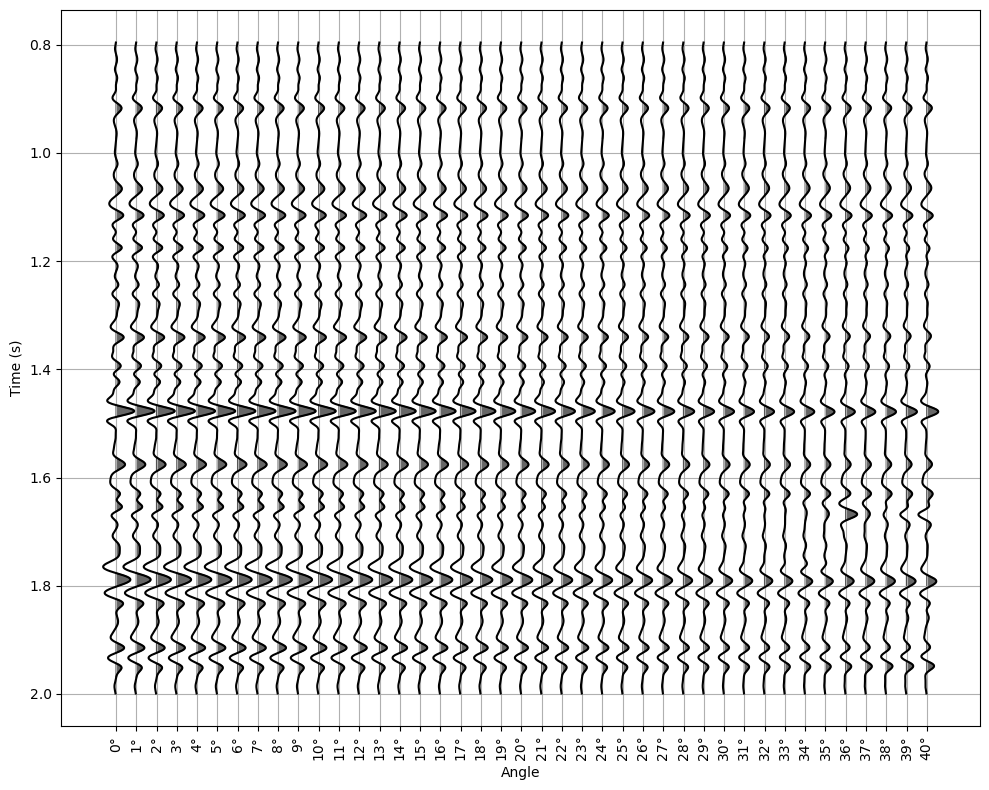

In [13]:
# # Plot gather
plt.figure(figsize=(10, 8))
scale = 0.4
num_angles = len(syn_df.columns)
xticks = []

for i, angle in enumerate(syn_df.columns):
    trace = syn_df[angle]
    offset = i * scale
    plt.plot(trace + offset, t, 'k')
    plt.fill_betweenx(t, offset, trace + offset, where=trace > 0, color='black', alpha=0.6)
    xticks.append(offset)

plt.gca().invert_yaxis()
plt.xlabel("Angle")
plt.ylabel("Time (s)")
plt.xticks(xticks, syn_df.columns, rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()
